# Simulations of a continuous-time quantum walk on a simple graph

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import expm_multiply
from scipy.sparse.linalg import expm
from scipy.stats import expon
import pandas as pd
import json
import time
import gc
import random

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

Function to obtain the Hamiltonian associated to a given graph and the transition rate

In [5]:
def giveMeHamiltonian(G, gamma, typeMatrix="laplacian"):
  # typeMatrix could be "adjacency" to use the adjacency matrix based Hamiltoninan 
  # or "laplacian" (default) to use the Laplacian matrix based Hamiltonian
  # gamma is the mutation rate 

  if typeMatrix == "adjacency":
    A = nx.adjacency_matrix(G)
  else:
    A = nx.laplacian_matrix(G)

  H = -gamma* A

  return H

Function to calculate the i-th canonical vector in $C^n$

In [6]:
def canonical_vector(i, n):
  # i-esimo vector canonico en C^n
  ei = np.zeros(n)
  ei[i] = 1.0
  return ei

Function to simulate a measurement of the quantum walk

In [7]:
def measurement(state, basis):
  # state is a vector in C^N

  qprobs = [abs(state[v])**2 for v in basis]
  collapse = np.random.choice(basis, p=qprobs)

  return collapse

In [27]:
def estimateTransitionMatrix(H, measurement_rate, N):
  # H is the Hamiltonian of the quantum walk
  # N is the number of realizations of the exponential random variable that determines the time at which we measure the quantum walk
  
  M = H.shape[0]

  times = expon.rvs(scale=1/measurement_rate, size=N)
  
  expected_matrix = np.zeros((M, M))

  computed_times = np.zeros(N)

  for k, t in enumerate(times):
    start = time.time()

    evolution_matrix = expm(-1j*t*H)

    for i in range(M):
      for j in range(M):
        expected_matrix[i, j] += abs(evolution_matrix[i,j])**2

    end = time.time()

    del evolution_matrix
    gc.collect()

    computed_times[k] = end-start
  
  expected_matrix = expected_matrix/N

  print("Average time =", computed_times.mean())

  return expected_matrix, computed_times

In [29]:
# hitting time (mean first passage time) to F of a discrete Markov chain 
def computeHittingTimes_d(transition_matrix, F):
  start = time.time()

  A = np.delete(transition_matrix, F, axis=0)
  A = np.delete(A, F, axis = 1)
  A = A - np.identity(A.shape[0])

  b = np.array([-1 for i in range(transition_matrix.shape[0] - len(F))])

  x = np.linalg.solve(A, b)

  for i in F:
    # F it is supposed to be ordered
    x = np.insert(x, i, 0)

  end = time.time()

  print(end-start)

  return x, end-start

In [30]:
# hitting time to F of a continuous quantum walk
def computeHittingTimes_q(hamiltonian, measurement_rate, F, N=500):
  T = estimateTransitionMatrix(hamiltonian, measurement_rate, N)
  return (1/measurement_rate)*computeHittingTimes_d(T, F)

In [31]:
def continuousQuantumWalk(graph, marked_nodes, initial_state, gamma, measurement_rate, max_simulation_time):
  finded = False

  M = graph.order()

  H = -gamma*nx.laplacian_matrix(graph).toarray()

  no_measurement = 0
  total_jumps = 0
  time = 0
 
  actual_state = initial_state 

  # Start of simulation
  while time < max_simulation_time:
    if actual_state in marked_nodes: # if we find one of the marked nodes
      finded = True
      break
      
    T = expon.rvs(scale=1/measurement_rate, size=1)[0] # time between measurements
    time += T
    
    # evolving quantum walk
    actual_state_vec = canonical_vector(actual_state, M) # vector representing genotype actual_state
    actual_state_vec = expm_multiply(-1j*T*H, actual_state_vec) # evolve quantum walk until time T with actual_state as initial state
    measurement_result = measurement(actual_state_vec, graph.nodes)
    no_measurement += 1

    if measurement_result != actual_state:
      total_jumps += 1

    actual_state = measurement_result
      
  # End of simulation
  
  simulations_results_aux = {'initial state': initial_state, 'transition rate': gamma, 'measurement rate': measurement_rate, 'simulation time': time, 
                             'total measurements': no_measurement, 'total jumps': total_jumps, 'finded': finded}

  return simulations_results_aux

# Simulations

In [16]:
G = nx.Graph()
G.add_nodes_from([i for i in range(16)])
G.add_edges_from([(0,1), (0,2), (1, 3), (1, 4), (2, 4), (2, 5), (3,6), (3,7), (4, 7), (4, 8), (5, 8), (5, 9), 
                  (6, 10), (7, 10), (7, 11), (8, 11), (8, 12), (9, 12), (10, 13), (11, 13), (11, 14), (12, 14), 
                  (13, 15), (14, 15)])

# colors of nodes
color_map = []
for v in G:
  if v == 0:
    color_map.append("green")
  elif v == 12 or v == 14 or v == 15:
    color_map.append("red")
  else:
    color_map.append("blue")

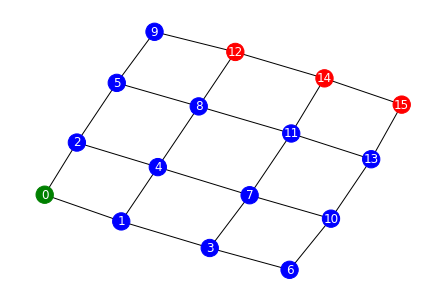

In [17]:
nx.draw(G, with_labels=True, node_color=color_map, font_color='white')

In [18]:
# marked nodes
F = [12, 14, 15] # grid example

In [19]:
measurement_rate = 0.5
gamma_q = 0.1 
H = -gamma_q*nx.laplacian_matrix(G).toarray()
max_simulation_time = 3000

In [20]:
initial_node = 0 

In [ ]:
T, compute_times = estimateTransitionMatrix(H, measurement_rate, N=5000)

In [ ]:
T.save("/content/drive/My Drive/Thesis/Code/newData/proof_concept/2d-grid-4-transition_matrix-gamma0.1-mr2.npy")

In [21]:
#T = np.load("/content/drive/My Drive/Thesis/Code/newData/proof_concept/2d-grid-4-transition_matrix-gamma0.1-mr2.npy")

In [22]:
hitting_times_qd = computeHittingTimes_d(T, F)[0]

0.0016803741455078125


In [23]:
hitting_times_qd

array([96.17544923, 94.64284947, 85.40828351, 92.70133192, 82.25930956,
       66.08042589, 91.49158971, 79.11145707, 56.27784158, 46.46794966,
       77.49085966, 50.94940538,  0.        , 49.09342077,  0.        ,
        0.        ])

In [24]:
hitting_times_q = (1/measurement_rate)*hitting_times_qd
hitting_times_q

array([192.35089847, 189.28569895, 170.81656701, 185.40266385,
       164.51861912, 132.16085177, 182.98317941, 158.22291414,
       112.55568316,  92.93589931, 154.98171933, 101.89881076,
         0.        ,  98.18684154,   0.        ,   0.        ])

In [ ]:
results_qw = pd.DataFrame()

In [ ]:
for i in range(2000):
  results_qw = results_qw.append(continuousQuantumWalk(graph=G, marked_nodes = F, initial_state=initial_node, gamma=gamma_q, measurement_rate=measurement_rate, max_simulation_time=max_simulation_time), ignore_index=True)

In [46]:
results_qw.to_csv("/content/drive/My Drive/Thesis/Code/hitting_time_paper/experiment_results.csv")

In [32]:
#results_qw = pd.read_csv("/content/drive/My Drive/Thesis/Code/hitting_time_paper/experiment_results.csv", index_col=0)

In [44]:
results_qw

,measurement rate,finded,initial state,simulation time,total jumps,total measurements,transition rate
0,0.5,1.0,0.0,487.333820,33.0,221.0,0.1
1,0.5,1.0,0.0,249.736517,21.0,108.0,0.1
2,0.5,1.0,0.0,131.682535,9.0,46.0,0.1
3,0.5,1.0,0.0,126.648172,10.0,73.0,0.1
4,0.5,1.0,0.0,81.469035,4.0,44.0,0.1
...,...,...,...,...,...,...,...
1995,0.5,1.0,0.0,140.670156,13.0,80.0,0.1
1996,0.5,1.0,0.0,271.232774,21.0,133.0,0.1
1997,0.5,1.0,0.0,406.150039,31.0,185.0,0.1
1998,0.5,1.0,0.0,105.350928,11.0,57.0,0.1


In [47]:
print("Number of simulations:", len(results_qw))
print("Average of number of measurements:", results_qw['total measurements'].mean())
print("Average of hitting times:", results_qw['simulation time'].mean())
print("\nExpected hitting time:", hitting_times_q[initial_node])
print("\nStandard deviation")
print("Standard deviation of number of measurements:", results_qw['total measurements'].std())
print("Standard deviation of hitting times:", results_qw['simulation time'].std())

Number of simulations: 2000
Average of number of measurements: 94.0085
Average of hitting times: 188.4391148825643

Expected hitting time: 192.35089846983217

Standard deviation
Standard deviation of number of measurements: 79.0777217096281
Standard deviation of hitting times: 155.6251541362211
